In [9]:
%load_ext autoreload
%autoreload 2
import os
from Utils.Utils import clean_trials, get_timestamps_from_rec, get_recording_time,plot_probe, assign_DIO_times_to_trials, Trim_TTLs, select_DIO_sync_trial_trace, stitch_bpod_times, select_DIO_channel, find_min_distance_TTL, call_trodesexport, check_single_rec_file, check_timestamps_gaps, get_mouse_name,get_recording_day, find_mat_files_with_same_day, check_gpu_availability
from pathlib import Path
import numpy as np
from spikeinterface.extractors import read_spikegadgets
from spikeinterface.sorters import run_sorter
from spikeinterface.preprocessing import detect_bad_channels
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import panel as pn
from tqdm.notebook import tqdm

pn.extension(design="bootstrap", sizing_mode="fixed",throttled=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# TODO:
# check gaps mouse 12 20240126
# check gaps mouse 13 20231212
# check timestamps.dat == spikeinterface times

# **Ott lab process single session**
#####  Multi-Neuropixels recording using SpikeGadgets + Bpod

## Imperative folder structure: n_animal/

- /n_animal
  - /ephys (it has to be called like this)
    - 20240126_184212.rec
    - 20240221_184222.rec
  - /bpod_session (it has to be called like this)
    - 20240126_184212
    - 20240221_184212

# Select file

In [12]:
# folder containing .rec file
#path_recording_folder = Path(r"/alzheimer/Roberto/Dariya/12/ephys/20231210_191835.rec")
path_recording_folder = Path(r"X:\R12\ephys\20231212_183552.rec")

mouse_n = get_mouse_name(path_recording_folder)
day = get_recording_day(path_recording_folder)
time = get_recording_time(path_recording_folder)
print(f"mouse {mouse_n} recorded on {day} at {time}")

path_recording, rec_file_name = check_single_rec_file(path_recording_folder)

mouse R12 recorded on 20231212 at 18:35:52
Exactly one .rec file found: 20231212_183552.rec


In [17]:
find_file(path_recording_folder, "timestamps.dat")

Found 0 timestamps.dat files


[]

In [18]:
from Utils.Utils import find_file
path_timestamps = find_file(path_recording_folder, "timestamps.dat")
if path_timestamps is None:
    print("Extracting timestamps using trodesexport -time")
    call_trodesexport(path_recording_folder, path_recording, "time")
    path_timestamps = find_file(path_recording_folder, "timestamps.dat")
print(f"Read timestamps from {path_timestamps[0]}")
timestamps_dict = readTrodesExtractedDataFile(path_timestamps[0])
timestamps = timestamps_dict["data"]["time"]
timestamps = timestamps - timestamps[0]

Found 0 timestamps.dat files


IndexError: list index out of range

## Extract timestamps from .rec file

In [30]:
%%time
# We adjust timestamps using the timestamps extracted from the .rec file. spikeinterface assumes no gaps (see https://spikeinterface.readthedocs.io/en/latest/modules_gallery/core/plot_6_handle_times.html) and hides all gaps in the recording.

timestamps = get_timestamps_from_rec(path_recording_folder,  path_recording)

Found 0 timestamps.dat files
Extracting timestamps using trodesexport -time
No folder with .time found.
Extract time
Command executed successfully
Found 1 timestamps.dat files
Read timestamps from X:\R12\ephys\20231212_183552.rec\20231212_183552.time\20231212_183552.timestamps.dat


C:\Users\SciencePerson\Documents\GitHub\spikesorting\Utils\TrodesToPython\readTrodesExtractedDataFile3.py:114: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


CPU times: total: 5.42 s
Wall time: 4min 21s


## Load recording in spikeinterface

In [32]:
%%time

raw_rec = read_spikegadgets(path_recording)

fs = raw_rec.get_sampling_frequency()

correct_times = timestamps/fs
raw_rec.set_times(correct_times) # set new times

print(f"Recording duration in minutes: {raw_rec.get_total_duration()/60}, sampling rate: {fs} Hz")
print(f"Probes present: {raw_rec.get_probes()}")

Recording duration in minutes: 154.06692055555555, sampling rate: 30000.0 Hz
Probes present: [Probe - 384ch - 1shanks, Probe - 384ch - 1shanks]
CPU times: total: 1.33 s
Wall time: 1.37 s


C:\Users\SciencePerson\miniforge3\envs\spikesorting\lib\site-packages\spikeinterface\core\baserecording.py:429: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated across preprocessingUse this carefully!
  warn(


In [33]:
gaps_start_stop = check_timestamps_gaps(raw_rec, correct_times)

No gaps detected.


# Sync Bpod and Trodes streams

### Export Digital IO channels

In [34]:
%%time
#check if already available, if not extract
call_trodesexport(path_recording_folder, path_recording, "dio")

.DIO folder alread available: 20231212_183552.DIO
CPU times: total: 0 ns
Wall time: 1.02 ms


In [35]:
DIO_timestamps_start_trial, DIO_samples_start_trial = select_DIO_sync_trial_trace(path_recording_folder, rec_file_name)

20231212_183552.dio_Controller_Din1.dat contains data
1 DIO files with data


## Load bpod mat file behavior

In [36]:
bpod_file = find_mat_files_with_same_day(path_recording_folder.parent.parent / "bpod_session" , path_recording_folder, raw_rec)

.mat file found: X:\R12\bpod_session\20231212_181618\12_AuditoryTuning_20231212_181618.mat
Bpod file starts within the Trodes recording
.mat file found: X:\R12\bpod_session\20231212_185101\12_DetectionConfidence_20231212_185101.mat
Bpod file starts within the Trodes recording


## Stitch trials and trim as needed

X:\R12\bpod_session\20231212_181618\12_AuditoryTuning_20231212_181618.mat
Bpod session started at 18:36:24, duration: 12.826175000000001 min, ended at: 18:49:13
number trials: 600
Extracting AuditoryTuning params
X:\R12\bpod_session\20231212_185101\12_DetectionConfidence_20231212_185101.mat
Bpod session started at 18:51:30, duration: 137.31311333333332 min, ended at: 21:08:48
number trials: 799
Extracting DetectionConfidence params
CPU times: total: 875 ms
Wall time: 1.28 s


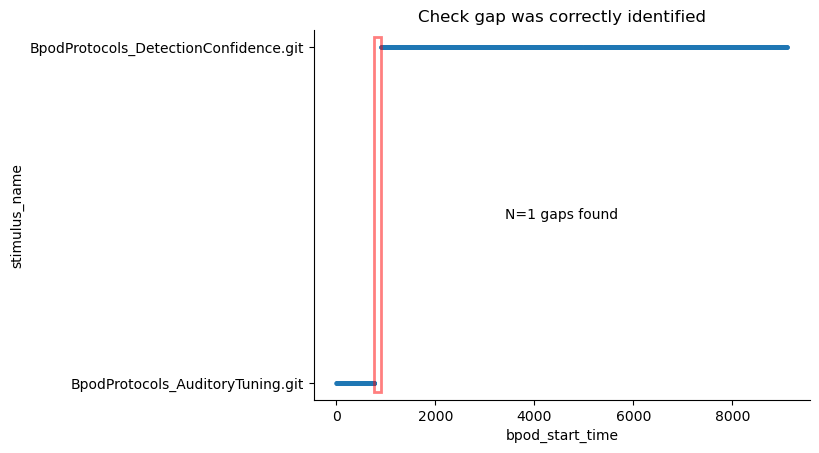

In [37]:
%%time
# currently can deal only with 2 behavior files, no more!
trials =  stitch_bpod_times(bpod_file, day, DIO_timestamps_start_trial)

len DIO:1400, len Bpod:1399
The most distant pulse in array1 is at index 1399 with time 9121.225866666666
This pulse has a minimum distance of 12.271066665649414 to the closest pulse in array2


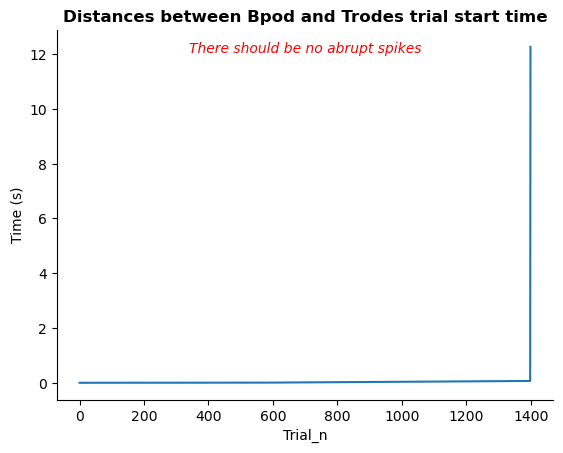

In [38]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

In [39]:
# only adapted to case where there is a extra TTL in the DIO at the end of last stimulus block!
DIO_timestamps_start_trial,  DIO_samples_start_trial = Trim_TTLs(trials, DIO_timestamps_start_trial, DIO_samples_start_trial,min_distances)

unequal numbers of trials between bpod and DIO
One extra TTL pulse received on DIO at the end of the session
extra TTL pulse removed


len DIO:1399, len Bpod:1399
The most distant pulse in array1 is at index 1398 with time 9109.022966666666
This pulse has a minimum distance of 0.06816666573286057 to the closest pulse in array2


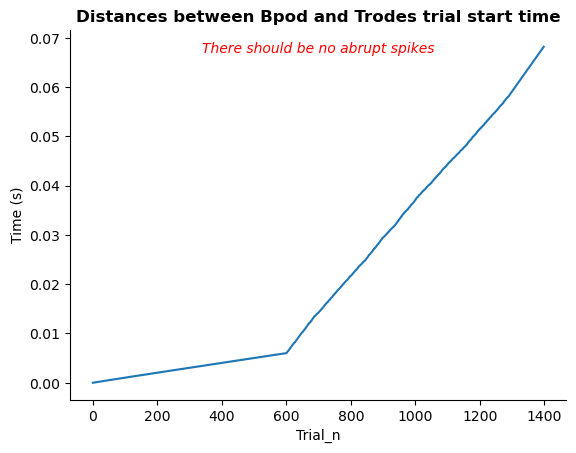

In [40]:
min_distances = find_min_distance_TTL(DIO_timestamps_start_trial,  trials["bpod_start_time"])

CPU times: total: 15.6 ms
Wall time: 9 ms


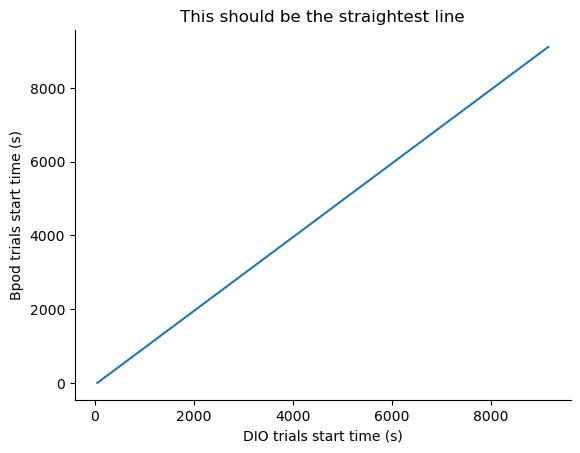

In [41]:
%%time
trials = assign_DIO_times_to_trials(trials, DIO_timestamps_start_trial, DIO_samples_start_trial)

## Final Trial df

In [42]:
%%time
cleaned_trials = clean_trials(trials, raw_rec, gaps_start_stop)

No trials discarded
CPU times: total: 78.1 ms
Wall time: 107 ms


In [43]:
cleaned_trials.to_csv(Path(f"{path_recording_folder}/trials.csv"))

In [44]:
pd.read_csv(Path(f"{path_recording_folder}/trials.csv"))

,trial_n,bpod_start_time,bpod_stop_time,stimulus_block,stimulus_name,Frequency,Volume,AfterTrialInterval,BeforeTrialInterval,Beta,...,WaitingTime,StimulusStartTime,RewardStartTime,DIO_start_sample,DIO_start_time,DIO_start_sample_zeroed,start_time,duration,stop_time,has_gap
0,0,1.1802,2.3802,0,BpodProtocols_AuditoryTuning.git,500.0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1591690,53.056333,0,0.000000,1.2,1.200000,False
1,1,2.4890,3.6890,0,BpodProtocols_AuditoryTuning.git,1000.0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1630955,54.365167,39265,1.308833,1.2,2.508833,False
2,2,3.7490,4.9490,0,BpodProtocols_AuditoryTuning.git,1500.0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1668755,55.625167,77065,2.568833,1.2,3.768833,False
3,3,5.0100,6.2100,0,BpodProtocols_AuditoryTuning.git,2000.0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1706585,56.886167,114895,3.829833,1.2,5.029833,False
4,4,6.2691,7.4691,0,BpodProtocols_AuditoryTuning.git,2500.0,60.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1744358,58.145267,152668,5.088933,1.2,6.288933,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,1394,9061.3978,9062.5978,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.262862,...,NaN,NaN,NaN,273400252,9113.341733,271808562,9060.285400,1.2,9061.485400,False
1395,1395,9073.5830,9074.7830,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.802172,...,NaN,NaN,NaN,273765811,9125.527033,272174121,9072.470700,1.2,9073.670700,False
1396,1396,9085.7843,9086.9843,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.519861,...,NaN,NaN,NaN,274131853,9137.728433,272540163,9084.672100,1.2,9085.872100,False
1397,1397,9097.9691,9099.1691,1,BpodProtocols_DetectionConfidence.git,NaN,NaN,1.0,1.0,0.108620,...,NaN,NaN,NaN,274497400,9149.913333,272905710,9096.857000,1.2,9098.057000,False


# Spike sorting

## Pre-processing

### Detect bad channels

In [153]:
%%time
if os.path.exists(f"{path_recording_folder}/channel_labels.csv"):
    channel_labels = pd.read_csv(f"{path_recording_folder}/channel_labels.csv")
else:
    bad_channel_ids_list = [] 
    channel_labels_list = []
    # detect noisy, dead, and out-of-brain channels
    split_preprocessed_recording = raw_rec.split_by("group")
    for group, sub_rec in tqdm(split_preprocessed_recording.items()):
        bad_channel_ids, channel_labels = detect_bad_channels(sub_rec)
    
        # count bad channels
        count = np.unique(channel_labels, return_counts=True)
        if (count[0].shape[0] == 1) & (count[0][0]=="good"):
             print(f"no bad channels in probe{group}")
        else:
            for n in range(count[0].shape[0]):
                print(f"{count[1][n]} {count[0][n]} channels in probe{group}")
                
        bad_channel_ids_list.append(bad_channel_ids)
        channel_labels_list.extend(channel_labels)
        
channel_labels = pd.DataFrame([channel_labels_list], index=[ "channel_labels"])
channel_labels.to_csv(f"{path_recording_folder}/channel_labels.csv", index=False)

CPU times: user 2.41 ms, sys: 0 ns, total: 2.41 ms
Wall time: 2.64 ms


### Inspect probes

Column(design=<class 'panel.theme.bootst...)
    [0] EditableRangeSlider(design=<class 'panel.theme.bootst..., end=3920.0, name='y_lim', step=10, value=(3120.0, 3720.0), width=300)
    [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, design=<class 'panel.theme.bootst...)
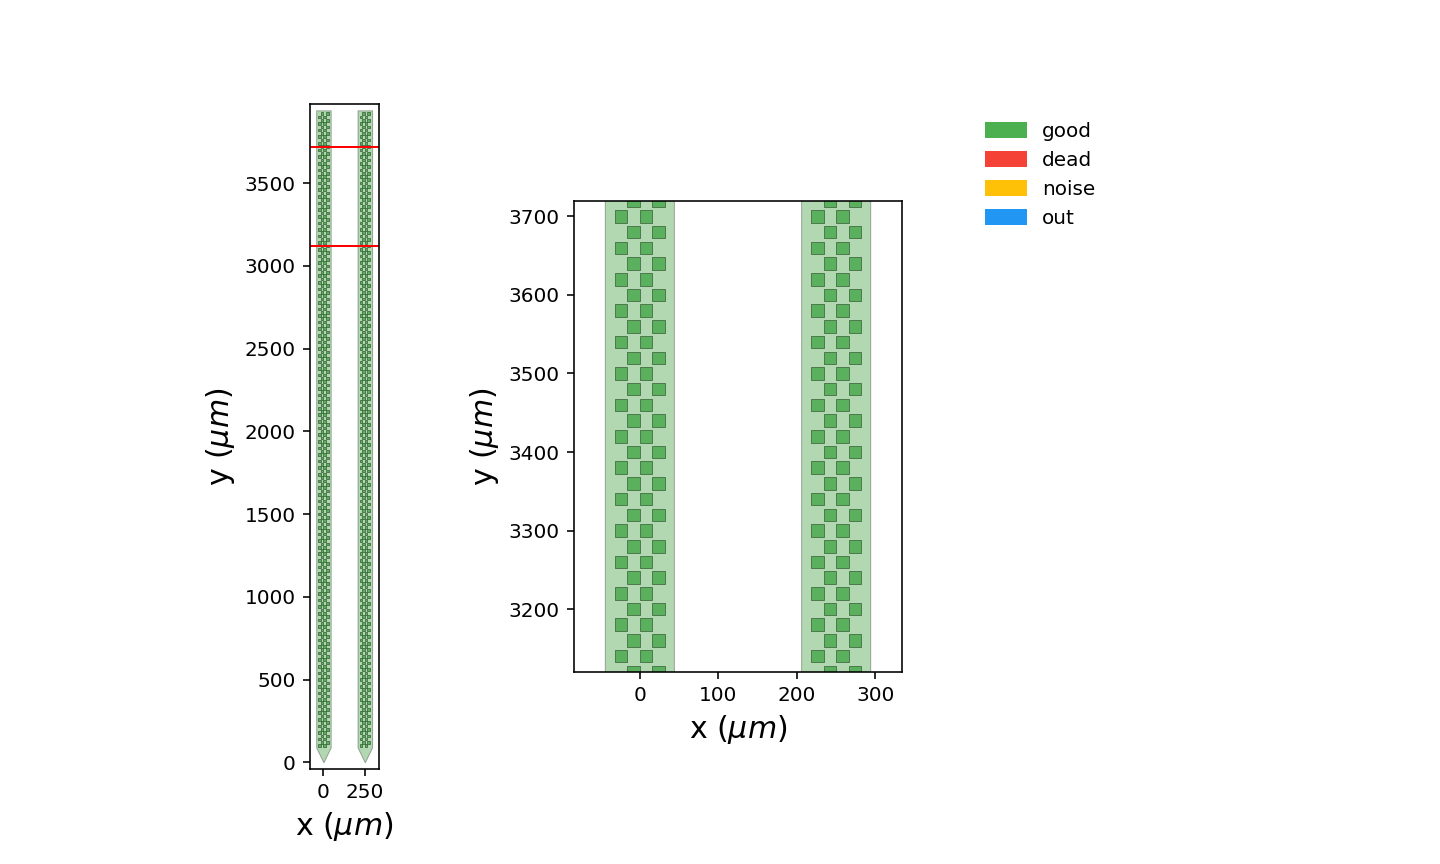

In [162]:
plot_probe(raw_rec, channel_labels.values.flatten())

In [ ]:
# remove bad channels
raw_rec = raw_rec.remove_channels(bad_channel_ids)
print("bad channels removed")

## Sorting

In [127]:
%%time

check_gpu_availability()

split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items():
    sorting = si.run_sorter(
        sorter_name="kilosort4",
        recording=sub_rec,
        output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}",
        verbose=True,
        remove_existing_folder=True
        )

GPU available: n = 1
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  14.91s; total  14.91s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [09:20<00:00,  1.06s/it]


drift computed in  575.12s; total  590.03s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [09:30<00:00,  1.08s/it]


2660635 spikes extracted in  579.12s; total  1169.15s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [11:29<00:00,  7.18s/it]


316 clusters found, in  690.26s; total  1859.41s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:26<00:00,  1.99it/s]


3289959 spikes extracted in  267.03s; total  2126.44s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [08:47<00:00,  5.50s/it]


281 clusters found, in  528.03s; total  2654.48s

Merging clusters
278 units found, in  2.77s; total  2657.25s

Saving to phy and computing refractory periods
51 units found with good refractory periods

Total runtime: 2693.37s = 00:44:53 h:m:s
kilosort4 run time 2695.52s
Loading recording with SpikeInterface...
number of samples: 31760248
number of channels: 384
numbef of segments: 1
sampling rate: 30000.0
dtype: int16
Preprocessing filters computed in  7.63s; total  7.63s

computing drift
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:42<00:00,  1.01it/s]


drift computed in  534.21s; total  541.84s

Extracting spikes using templates
Re-computing universal templates from data.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [08:45<00:00,  1.01it/s]


2663567 spikes extracted in  535.87s; total  1077.71s

First clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [09:24<00:00,  5.88s/it]


280 clusters found, in  564.46s; total  1642.17s

Extracting spikes using cluster waveforms


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [04:31<00:00,  1.96it/s]


2707619 spikes extracted in  271.49s; total  1913.66s

Final clustering


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [05:45<00:00,  3.59s/it]


269 clusters found, in  345.05s; total  2258.72s

Merging clusters
265 units found, in  2.20s; total  2260.92s

Saving to phy and computing refractory periods
41 units found with good refractory periods

Total runtime: 2293.39s = 00:38:13 h:m:s
kilosort4 run time 2295.68s
CPU times: user 19h 59min 21s, sys: 28min 21s, total: 20h 27min 42s
Wall time: 1h 23min 19s


# Post-processing

## Manual curation with Phy

### Add custom metrics in phy

In [235]:
from spikeinterface.core import write_binary_recording
from Utils.Settings import job_kwargs
from Utils.Paths import conda_path
from spikeinterface import create_sorting_analyzer

In [ ]:
%%time
split_preprocessed_recording = raw_rec.split_by("group")

for group, sub_rec in split_preprocessed_recording.items():
    write_binary_recording( sub_rec, file_paths=f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/recording.dat", **job_kwargs)

    with (f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/params.py").open("w") as f:
            f.write(f"dat_path = r'recording.dat'\n")

    # compute 'isi_violation', 'presence_ratio' to add to phy
    analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="memory", **job_kwargs , 
                                           folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer")

    analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                  "templates": dict(),
                   "noise_levels":dict(),
                  "quality_metrics": dict(metric_names=['isi_violation', 'presence_ratio'])})
    metrics = analyzer.get_extension('quality_metrics').get_data()
    metrics.index.name="cluster_id"
    metrics.reset_index(inplace=True)
    #create .tsv files in sorter_output folder
    for metric in ['isi_violation', 'presence_ratio']:
        metrics[["cluster_id", metric]].to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_{metric}.tsv", sep="\t", index=False)

    # Use ks labels as default
    kslabels = pd.read_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_KSLabel.tsv", sep="\t")
    kslabels.rename(columns={"KSLabel": "group"}, inplace=True)
    kslabels.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/cluster_group.tsv", sep="\t", index=False)

### Open phy

In [292]:
group = 0

In [293]:
dynamic_path = f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output"  # Set your path here

! source $conda_path && conda activate phy2 && cd $dynamic_path && phy template-gui params.py


17:12:35.098 [W] model:667            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
[3055417:7:0426/171241.855654:ERROR:command_buffer_proxy_impl.cc(141)] ContextResult::kTransientFailure: Failed to send GpuChannelMsg_CreateCommandBuffer.
[3055418:7:0426/171241.855821:ERROR:command_buffer_proxy_impl.cc(141)] ContextResult::kTransientFailure: Failed to send GpuChannelMsg_CreateCommandBuffer.
17:17:37.108 [I] supervisor:700       Merge clusters 0, 1 to 278.
^C


# Calculate metrics on selected clusters

In [ ]:
from spikeinterface.extractors import read_phy
from spikeinterface import create_sorting_analyzer, load_sorting_analyzer
from spikeinterface.qualitymetrics import compute_quality_metrics, get_quality_metric_list, get_quality_pca_metric_list
from spikeinterface.sorters import read_sorter_folder
from spikeinterface.postprocessing import compute_template_metrics
from spikeinterface.exporters import export_to_phy
from spikeinterface.core import write_binary_recording

In [32]:
%%time

# Here we calculate the following metrics: ['num_spikes','firing_rate','presence_ratio','snr','isi_violation','rp_violation','sliding_rp_violation','amplitude_cutoff','amplitude_median','amplitude_cv','synchrony','firing_range','drift','sd_ratio']
 
split_preprocessed_recording = raw_rec.split_by("group")
for group, sub_rec in split_preprocessed_recording.items(): # we do this on single probes, save space!
    if os.path.exists(f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer/"):
        analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer/")
    else:
        print(f"Processing probe{group}")
        sorting = read_phy(f"{path_recording_folder}/spike_interface_output/probe{group}/sorter_output/")
        analyzer = create_sorting_analyzer(sorting, sub_rec, sparse=True, format="binary_folder", n_jobs=20, chunk_duration='30s', progress_bar=True, 
                                           folder=f"{path_recording_folder}/spike_interface_output/probe{group}/sorting_analyzer") # job params propagate
        analyzer.compute({"random_spikes": dict(method="uniform", max_spikes_per_unit=500), 
                          "waveforms":  dict(ms_before=1,ms_after=2.),
                         "templates": dict(operators=["average", "std"]),
                         "noise_levels":dict(), 
                          'correlograms':dict() ,
                         'spike_amplitudes':dict(),
                         'unit_locations':dict(method="monopolar_triangulation"),
                         'template_similarity':dict(),
                         "template_metrics":dict(include_multi_channel_metrics=True),
                         "spike_locations":dict(),
                         "quality_metrics": dict(metric_names=get_quality_metric_list())})

        #analyzer.compute("principal_components", **job_kwargs)
        
        metrics = pd.concat([metrics, analyzer.get_extension("template_metrics").get_data()], axis=1)# add template metrics
        metrics["probe_n"] = f"probe{group}"
        
        metrics.to_csv(f"{path_recording_folder}/spike_interface_output/probe{group}/metrics")


Processing probe0


estimate_sparsity:   0%|          | 0/36 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/1059 [00:00<?, ?it/s]

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/sklearn/linear_model/_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/sklearn/linear_model/_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/sklearn/linear_model/_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/sklearn/linear_model/_theil_sen.py:128: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/alzheimer/Roberto/S

Compute : spike_amplitudes + spike_locations:   0%|          | 0/1059 [00:00<?, ?it/s]

/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/sortingcomponents/peak_localization.py:215: RuntimeWarning: invalid value encountered in divide
  coms = np.dot(wf_data, local_contact_locations) / (np.sum(wf_data, axis=1)[:, np.newaxis])
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:880: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide

CPU times: user 13min 52s, sys: 3min 36s, total: 17min 28s
Wall time: 12min 54s


In [82]:
si.get_template_extremum_amplitude(analyzer)

{0: 2.3954596519470215,
 1: 32.328617095947266,
 2: 60.35238265991211,
 3: 189.92311096191406,
 4: -0.0,
 5: 1.8408143520355225,
 6: 91.21063232421875,
 7: 100.03543090820312,
 8: -0.0,
 9: 49.462623596191406,
 10: -0.0,
 11: 56.25676727294922,
 12: 1.8157645463943481,
 13: 136.17788696289062,
 14: -0.0,
 15: -0.0,
 16: -0.0,
 17: 127.95379638671875,
 18: 69.46692657470703,
 19: 66.54749298095703,
 20: 361.9164123535156,
 21: 32.401973724365234,
 22: 6.7512688636779785,
 23: 164.82566833496094,
 24: 75.86808013916016,
 25: 1.1949092149734497,
 26: 217.67869567871094,
 27: 260.3925476074219,
 28: 67.3272476196289,
 29: 43.20925521850586,
 30: 149.94393920898438,
 31: -0.0,
 32: 63.04146194458008,
 33: 4.684933185577393,
 34: 39.49567413330078,
 35: 88.0630874633789,
 36: 95.41625213623047,
 37: 60.08255386352539,
 38: 0.6057077050209045,
 39: 57.3911247253418,
 40: 104.39668273925781,
 41: 1.8130919933319092,
 42: -0.0,
 43: 148.60287475585938,
 44: 134.3810272216797,
 45: -0.0,
 46: 86

In [114]:
pd.DataFrame(analyzer.get_channel_locations())

,0,1
0,8.0,100.0
1,-24.0,100.0
2,8.0,340.0
3,-24.0,340.0
4,8.0,580.0
...,...,...
763,242.0,3440.0
764,274.0,3680.0
765,242.0,3680.0
766,274.0,3920.0


In [81]:
si.get_template_extremum_channel(analyzer, outputs="index")

{0: 65,
 1: 1,
 2: 129,
 3: 129,
 4: 129,
 5: 257,
 6: 257,
 7: 385,
 8: 449,
 9: 385,
 10: 576,
 11: 513,
 12: 641,
 13: 641,
 14: 705,
 15: 3,
 16: 130,
 17: 3,
 18: 3,
 19: 3,
 20: 3,
 21: 259,
 22: 130,
 23: 259,
 24: 259,
 25: 386,
 26: 451,
 27: 451,
 28: 515,
 29: 515,
 30: 515,
 31: 515,
 32: 578,
 33: 707,
 34: 706,
 35: 578,
 36: 643,
 37: 5,
 38: 68,
 39: 68,
 40: 5,
 41: 68,
 42: 69,
 43: 133,
 44: 133,
 45: 197,
 46: 133,
 47: 196,
 48: 133,
 49: 325,
 50: 324,
 51: 261,
 52: 325,
 53: 325,
 54: 261,
 55: 324,
 56: 261,
 57: 325,
 58: 389,
 59: 389,
 60: 389,
 61: 388,
 62: 388,
 63: 517,
 64: 517,
 65: 517,
 66: 580,
 67: 517,
 68: 581,
 69: 708,
 70: 645,
 71: 645,
 72: 709,
 73: 709,
 74: 325,
 75: 645,
 76: 645,
 77: 7,
 78: 71,
 79: 198,
 80: 135,
 81: 263,
 82: 199,
 83: 709,
 84: 263,
 85: 326,
 86: 519,
 87: 391,
 88: 455,
 89: 519,
 90: 582,
 91: 519,
 92: 647,
 93: 711,
 94: 73,
 95: 73,
 96: 265,
 97: 329,
 98: 584,
 99: 521,
 100: 584,
 101: 649,
 102: 10,
 103

In [77]:
analyzer.get_channel_locations()

array([[   8.,  100.],
       [ -24.,  100.],
       [   8.,  340.],
       ...,
       [ 242., 3680.],
       [ 274., 3920.],
       [ 242., 3920.]])

In [70]:
analyzer = load_sorting_analyzer(folder=f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer_allchan")

In [92]:
analyzer.get_extension("unit_locations").get_data()[:5]

array([[-51.72229221, 128.52032825,   3.39921508],
       [-48.24928543, 110.09615969,   2.00707626],
       [-33.93869908, 184.41437656,   1.53194314],
       [-28.45047553, 180.32792834,   1.66825795],
       [-33.42324987, 185.32340784,   1.62044861]])

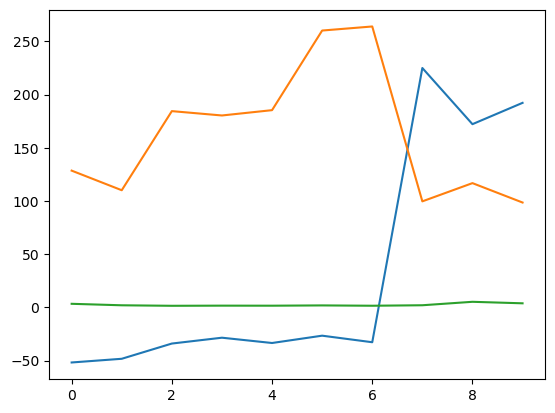

In [94]:
plt.plot(analyzer.get_extension("unit_locations").get_data()[:10])

In [43]:
from spikeinterface.widgets import plot_sorting_summary

TypeError: 'NoneType' object is not subscriptable

In [49]:
metrics["amplitude_cutoff"]

0      0.000029
1      0.002922
2      0.000303
3      0.002027
4      0.000332
         ...   
273         NaN
274    0.000041
275    0.000402
276    0.000236
277    0.001029
Name: amplitude_cutoff, Length: 278, dtype: float64

In [60]:
%%time
export_to_phy(analyzer, output_folder=f"{path_recording_folder}/spike_interface_output/probe{group}/phy", copy_binary=True, verbose=True, n_jobs=20, chunk_duration='30s', progress_bar=True)
        
    

write_binary_recording:   0%|          | 0/36 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/36 [00:00<?, ?it/s]

Process ForkProcess-103:
Process ForkProcess-111:
Process ForkProcess-102:
Process ForkProcess-119:
Process ForkProcess-109:
Process ForkProcess-104:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-118:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/alzheimer/Roberto/Software/mambaforge/envs/spikesorting/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/alzheimer/Roberto/

KeyboardInterrupt: 

In [52]:
group=0

In [ ]:
%%time

No gaps detected.


# Trash

### Export Analog IO channels

In [160]:
%%time
extract_analogIO(path_recording_folder, path_recording)# 55 min too slow


'.analog' folder alread available: 20231212_183552.analog
CPU times: user 553 µs, sys: 109 µs, total: 662 µs
Wall time: 770 µs


### Export timestamps

In [161]:
%%time
#extract_time(path_recording_folder, path_recording) # slower than analogIO somehow!!

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


## Load Trodes timestamps

In [174]:
path_analogIO_folder = Path(path_recording_folder,  f"{rec_file_name[:rec_file_name.rfind('.')]}.analog")

In [521]:
from Utils.TrodesToPython.readTrodesExtractedDataFile3 import readTrodesExtractedDataFile, get_Trodes_timestamps
analog_dict = readTrodesExtractedDataFile(Path(path_analogIO_folder, f"{rec_file_name[:rec_file_name.rfind('.')]}.timestamps.dat"))

NameError: name 'path_analogIO_folder' is not defined

In [178]:
analog_dict["data"].shape

(277320457,)

In [179]:
raw_rec.get_total_samples()

277320457

In [640]:
%%time
kilosort_timestamp2 = get_Trodes_timestamps(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat"))

CPU times: user 849 µs, sys: 467 ms, total: 468 ms
Wall time: 465 ms


In [643]:
kilosort_timestamp2

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [187]:
analog_dict["data"]["time"]

array([  1279032,   1279033,   1279034, ..., 278599486, 278599487,
       278599488], dtype=uint32)

In [641]:
%%time
kilosort_timestamp = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestamps.dat"))

CPU times: user 0 ns, sys: 452 ms, total: 452 ms
Wall time: 449 ms


In [638]:
kilosort_timestamp["data"]["time"]

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [671]:
analog_timestamp = readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20240126_184212.rec/test/20240126_184212.timestampsanalog.dat"))

In [608]:
np.unique(np.diff(analog_timestamp["data"]["time"]))

array([   1,    2,    3,  691, 1437, 2094, 2374, 2375, 2390, 2391],
      dtype=uint32)

In [609]:
np.unique(np.diff(kilosort_timestamp["data"]["time"]))

array([   1,    2,    3,  691, 1437, 2094, 2374, 2375, 2390, 2391],
      dtype=uint32)

In [539]:
np.unique(np.diff(raw_rec.get_times()))

array([3.33333328e-05, 3.33333332e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333333e-05, 3.33333333e-05, 3.33333333e-05,
       3.33333333e-05, 3.33333334e-05, 3.33333335e-05, 3.33333337e-05])

In [601]:
raw_rec.get_times()

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       7.48217130e+03, 7.48217133e+03, 7.48217137e+03])

In [604]:
(analog_timestamp["data"]["time"]- analog_timestamp["data"]["time"][0]) / 30000.0

array([0.00000000e+00, 3.33333333e-05, 6.66666667e-05, ...,
       7.48315943e+03, 7.48315947e+03, 7.48315950e+03])

In [513]:
analog_timestamp["data"]["time"]

array([  2871885,   2871886,   2871887, ..., 227366668, 227366669,
       227366670], dtype=uint32)

In [655]:
%%time
t=readTrodesExtractedDataFile(Path("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/20231212_183552.analog/20231212_183552.analog_Headstage_GyroX.dat"))

CPU times: user 3.59 ms, sys: 1.66 s, total: 1.66 s
Wall time: 6.6 s


In [670]:
path_timestamps = find_file("/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/", "timestamps.dat")
path_timestamps

Found 1 timestamps.dat files


['/alzheimer/Roberto/Dariya/12/ephys/20231212_183552.rec/20231212_183552.analog/20231212_183552.timestamps.dat']

In [666]:
path_timestamps

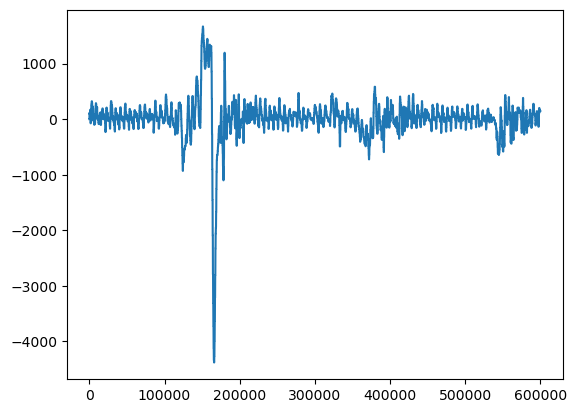

In [657]:
plt.plot(t["data"]["voltage"][:30000*20])

## save space

In [41]:
analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer_allchan/")
analyzer

SortingAnalyzer: 768 channels - 278 units - 1 segments - binary_folder - sparse - has recording
Loaded 10 extensions: spike_amplitudes, waveforms, unit_locations, template_similarity, templates, template_metrics, random_spikes, noise_levels, correlograms, quality_metrics

In [42]:
analyzer = load_sorting_analyzer(f"{path_recording_folder}/spike_interface_output/probe0/sorting_analyzer/")
analyzer

SortingAnalyzer: 384 channels - 278 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extensions: spike_amplitudes, template_similarity, random_spikes, templates, spike_locations, unit_locations, noise_levels, correlograms, waveforms, template_metrics, quality_metrics